<a href="https://colab.research.google.com/github/Git-Hub-Pro/license_plate_recognition/blob/master/license_plate_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [100]:
# Install pytesseract and tesseract-OCR in google colab.
# pytesseract 은 글자 인식을 해주는 오픈 소스이다.
# 참고 : https://medium.com/@bhadreshpsavani/how-to-use-tesseract-library-for-ocr-in-google-colab-notebook-5da5470e4fe0
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libtesseract-dev is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract

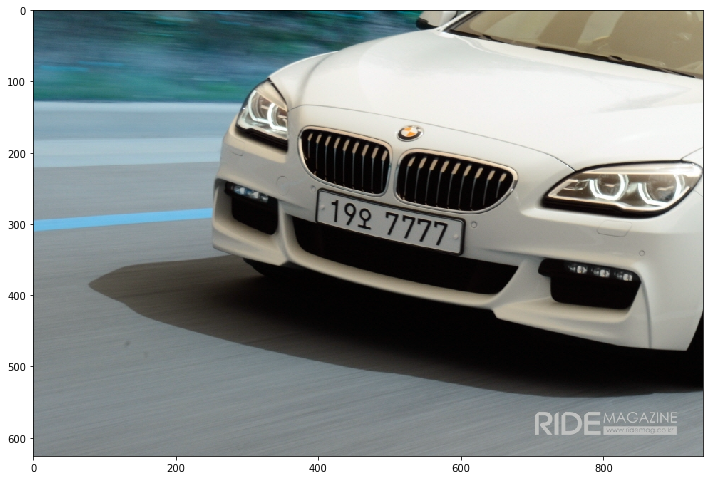

In [102]:
# Read Input Image
img_ori = cv2.imread("/content/gdrive/My Drive/data/license_plate/1.jpg")

height, width, channel = img_ori.shape

plt.figure(figsize=(12,10))
plt.imshow(img_ori,cmap='gray')

In [103]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


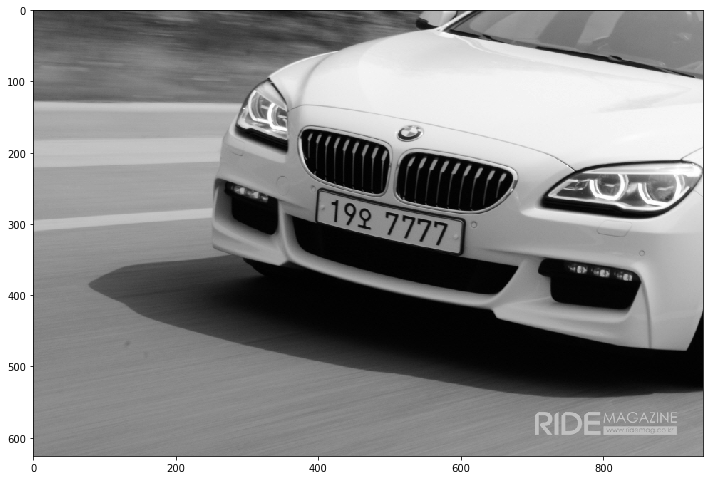

In [104]:
# Convert Image to Grayscale
gray = cv2.cvtColor(img_ori,cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12,10))
plt.imshow(gray,cmap='gray')

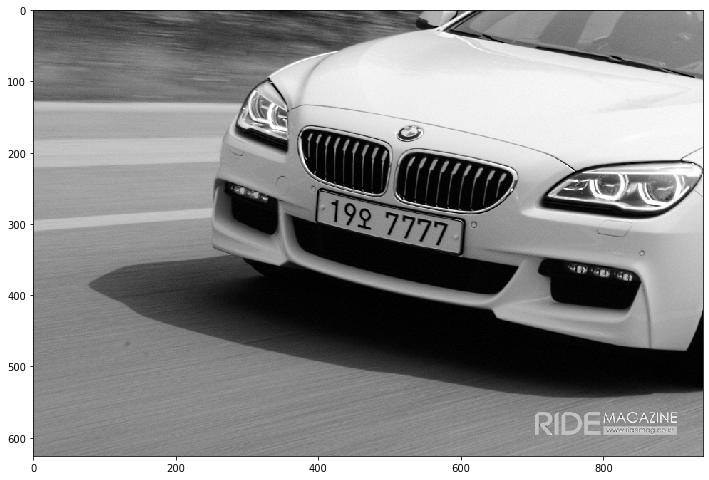

In [105]:
# Maximize Contrast (Optional) / 침식-팽창 알고리즘, 윤곽선을 좀 더 명확하게 하기 위해 사용된다.
# Opening : Erosion 적용 후, Dilation 적용, 작은 Object나 돌기 제거에 적합.
# Closing : Dilation 적용 후 Erosion 적용, 전체적인 윤곽 파악에 적합.
# cv2.morphologyEx(src,op,kernel[,dst[,anchor,[,literation[,borderType[,borderValue]]]]])
# src - source img , op -Type of a morphological kerenl - strucutring element ahchor - structuring element 의 중심 iterations - 침식 팽창 적용횟수
# op type
# MORPH_OPEN : an opening operation , MORPH_CLOSE : a closing operation , MORPH_GRADIENT : dilation과 erosion 차이
# MORPH_TOPHAT : "top hat". Opening과 원본 이미지의 차이 MORPH_BLACKHAT : "black hat" closing과 원본 이미지의 차이
# cv2.getStrucuringElement(shape,ksize[,anchor])-> retval
# shape -Element 의 모양 MORPH_RET : 사각형 모양 MORPH_ELLIPSE: 타원형 모양 MORPH_CROSS : 십자 모양 ksize : structuring element 사이즈
# 참고 사이트 : https://opencv-python.readthedocs.io/en/latest/doc/12.imageMorphological/imageMorphological.html
structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)
imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat)
gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

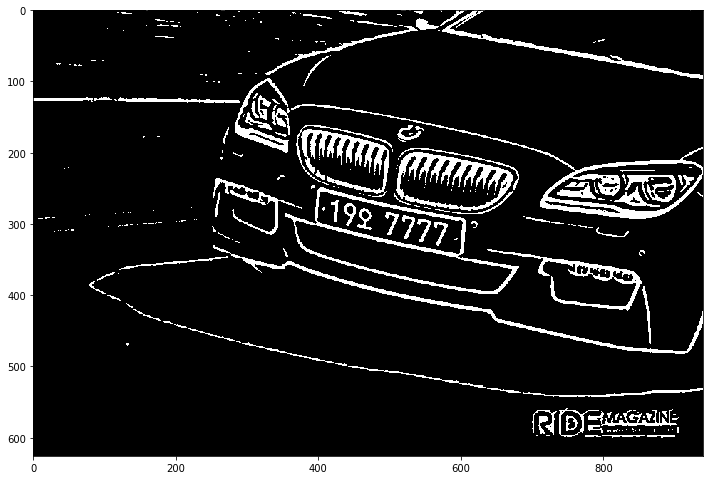

In [106]:
# Adaptive Thresholding
# 적응 임계처리
# 기본 임계처리는 임계값을 이미지 전체에 적용하여 처리하기 때문에 하나의 이미지에 음영이 다르면 일부 영역이 모두 흰색 또는 검정색으로
# 보여지게 됩니다. 이런 문제를 해결하기 위해 이미지의 작은 영역별로 thresholding을 하는 것입니다. 이때 사용하는 함수가 
# adaptiveThreshold입니다.
# cv2.adaptiveThreshold(src,maxvalue,adaptiveMethod,thresholdType,blockSize,C)
# src - grayscale image , maxValue - 최대값, adaptiveMehtod : thresholding value를 결정하는 방법,thresholdType:threshold type
# blocksize = thresholding을 적용할 영역 사이즈, C-평균이나 가중평균에서 차감할 값
# Adaptive mehod 
# cv2.ADAPTIVE_THRESH_MEAN_C : 주변 영역의 평균값으로 결정
# cv2.ADAPTIVE_THRESH_GAUSSIAN_C : 정규분포의 평균.

# Image Filtering 
# 이미지도 음성 신호처럼 주파수로 표현할 수 있습니다. 일반적으로 고주파는 밝기의 변화가 많은 곳, 즉 경계선 영역에서 나타나며,
# 일반적으로 배경은 저주파로 나타납니다. 이것을 바탕으로 고주파를 제거하면 Blur 처리가 되며, 저주파를 제거하면 대상의 영역을 확인할 수 있습니다.
# cv.blur(src,ksize) 
# Gaussian Filtering (Gaussian 함수를 이용한 kernel을 적용합니다.)
# kernel 사이즈는 양수이면서 홀수로 지정을 해야 합니다. 이미지의 Gaussian Noise(전체적으로 밀도가 동일한 노이즈, 백색노이즈)를 제거하는 데 효과적입ㄴㅣ다.
# cv2.GaussianBlur(img,ksize,sigmaX)
# img, ksize, sigmaX : gaussian kernel standard deviation in X direction
# 참고 사이트:https://opencv-python.readthedocs.io/en/latest/doc/11.imageSmoothing/imageSmoothing.html
img_blurred = cv2.GaussianBlur(gray,ksize=(5,5),sigmaX=0)

img_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

plt.figure(figsize=(12,10))
plt.imshow(img_thresh,cmap='gray')

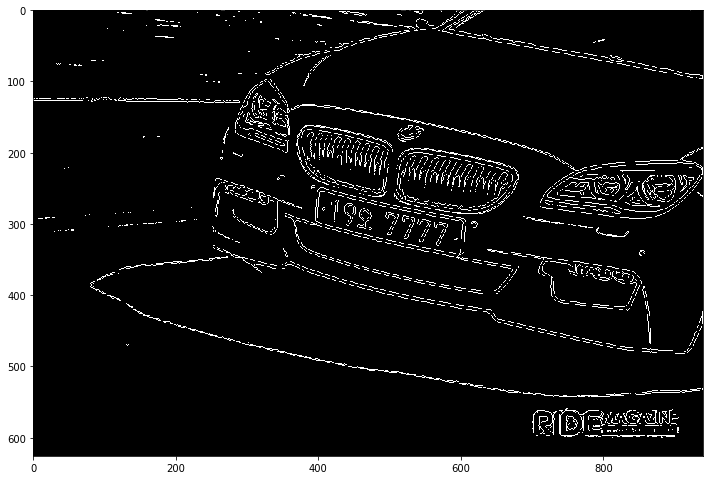

In [107]:
# Find Contours
# Contours란 동일한 색 또는 동일한 강도를 가지고 있는 영역의 경계선을 연결한 선입니다. 우리가 자주 보는 등고선이나 일기예보에서 볼수 있습니다..
# 정확도를 높히기 위해서 Binary Image를 사용합니다. threshold나 canny edge를 선처리로 수행합니다.
# cv2.findContours() 함수는 원본 이미지를 직접 수정하기 때문에, 원본 이미지를 보존하려면 Copy해서 사용해야 합니다.
# OpenCV에서는 contours를 찾는 것은 검은색 배경에서 하얀색 대상을 찾는 것과 비슷합니다. 그래서 대상은 흰색, 배경은 검은색으로 해야 합니다..
# cv2.findContours(image,mode,method[,contours[,hiearchy[,offset]]]) -> image, contours, hierarchy
# image - 8-bit single-channel image.binary image.
# mode - cv2.RETR_EXTERNAL : contours line 중 가장 바깥쪽 Line만 찾음. / 컨투어 라인 중 가장 바깥쪽의 라인만 찾음.
#        cv2.RETR_LIST : 모든 contours line을 찾지만, hierachy 관계를 구성하지 않음. // 모든 컨투어 라인을 찾지만, 상하구조 관계를 구성하지 않음.
#        cv2.RETR_CCOMP : 모든 contours line을 찾으며, hieracy 관계는 2-level로 구성한다. / 모든 컨투어 라인을 찾고, 상하구조는 2 단계로 구성함.
#        cv2.RETR_TREE : 모든 contours line을 찾으며,, 모든 hieracy 관계를 구성함. / 모든 컨투어 라인을 찾고, 모든 상하구조를 구성함.

# method - contours를 찾을 때 사용하는 근사치 방법
#        cv2.CHAIN_APPROSX_NONE: 모든 contours point 저장.  / 모든 컨투어 포인트를 반환
#        cv.CHAIN_APPROX_SIMPLE : contours line을 그릴 수 있는 point만 저장.(ex. 사각형이면 4개) / 컨투어 라인을 그릴 수 있는 포인트만 반환
#        cv2.CHAIN_APPROX_TC89_L1 / Teh_chin 연결 근사 알고리즘 L1 버전을 적용하여 컨투어 포인트를 줄임.
#        cv2.CHAIN_APPROX_TC89_KCOS : contours point를 찾는 알고리즘 // Teh_chin 연결 근사 알고리즘 KCOS 버전을 적용하여 컨투어 포인트를 줄임.
# 컨투어 특징
# 이미지 모멘트는 컨투어에 대한 특징값을 뜻한다. OpenCV에서는 moments 함수로 이미지 모멘트를 구한다. 컨투어 포인트 배열을 입력하면
# 해당 컨투어 포인트 배열을 입력하면 해당 컨투어의 모멘트를 딕셔너리 타입으로 반환한다. 반환하는 모멘트는 총 24개로 10개의 위치 모멘트.
# 7개의 중심 모멘트, 7개의 정규화된 중심 모덴트로 이루어져있다.

#cv2.drawContours(image,contours,contourIdx,color[,thickness[,lineType[,hierarchy[,maxLevel[,offset]]]]]) -> dst
# parameters : image - 원본 이미지, contours - contour 정보,contourIdx : contours list type에서 몇번째 contours line을 그릴 거신지, -1이면 전체
#              color - contours line color , thickness - contours line의 두께 , 음수이며ㄴ contours line의 내부를 채움.
# returns : image에 contours 가 그려진 결과
#
# boundingRect : straight Bounding Rectangle : 물체의 회전을 고려하지 않은 사각형
# minAreaRect : Rotated Rectangle : 물체의 회전을 고려한 사각형.
# 참고:https://datascienceschool.net/view-notebook/f9f8983941254a34bf0fee42c66c5539/
#     https://opencv-python.readthedocs.io/en/latest/doc/15.imageContours/imageContours.html

contours, hierarchy = cv2.findContours(img_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)

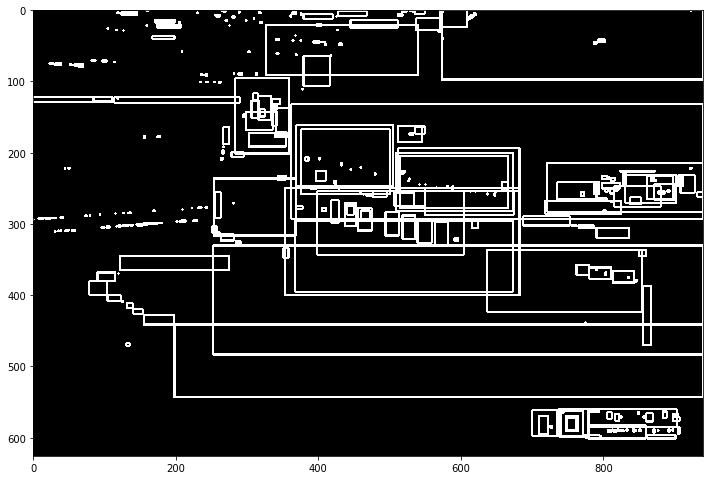

In [108]:
# 사각형 그리기. top-left corner와 bottom-right corner점을 연결하는 사각형을 그립니다.
# cv2.rectangle(img,start,end,color,thickness)
# parameters : img - 그림을 그릴 이미지 , start - 시작좌표(ex:0,0) end - 종료좌표(ex,(500,500)), color - BGR 형태 ,, thickness - 두께
# prepare Data
temp_result = np.zeros((height,width,channel),dtype=np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result,pt1=(x,y),pt2=(x+w,y+h),color=(255,255,255),thickness=2)

    # insert to dict
    contours_dict.append({
     'contour':contour,
     'x':x,
     'y':y,
     'w':w,
     'h':h,
     'cx':x+(w/2),
     'cy':y+(h/2)
    }) 
plt.figure(figsize=(12,10))
plt.imshow(temp_result,cmap='gray')

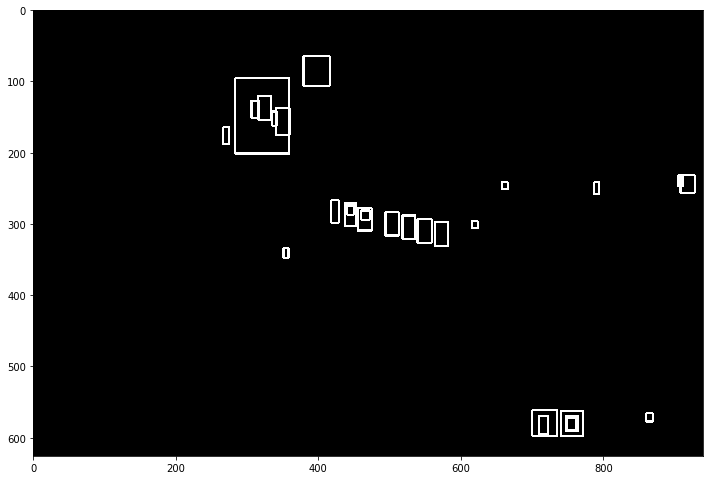

In [109]:
# select candidates by char size (사각형의 크기를 통하여 후보군을 고른다.) 규격된 사이즈이기 때문에 아래와 같은 방법으로 찾을 수 있다.
MIN_AREA = 80
MIN_WIDTH,MIN_HEIGHT = 2,8
MIN_RATIO, MAX_RATIO = 0.25, 1.0

possible_contours = []

cnt =0
for d in contours_dict:
    area = d['w']*d['h']
    ratio = d['w']/d['h']

    if area > MIN_AREA and d['w']>MIN_WIDTH and d['h'] > MIN_HEIGHT and MIN_RATIO < ratio < MAX_RATIO:
      d['idx'] = cnt
      cnt += 1
      possible_contours.append(d)

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
  cv2.rectangle(temp_result,pt1=(d['x'],d['y']),pt2=(d['x']+d['w'],d['y']+d['h']),color=(255,255,255),thickness=2)

plt.figure(figsize=(12,10))
plt.imshow(temp_result,cmap='gray')

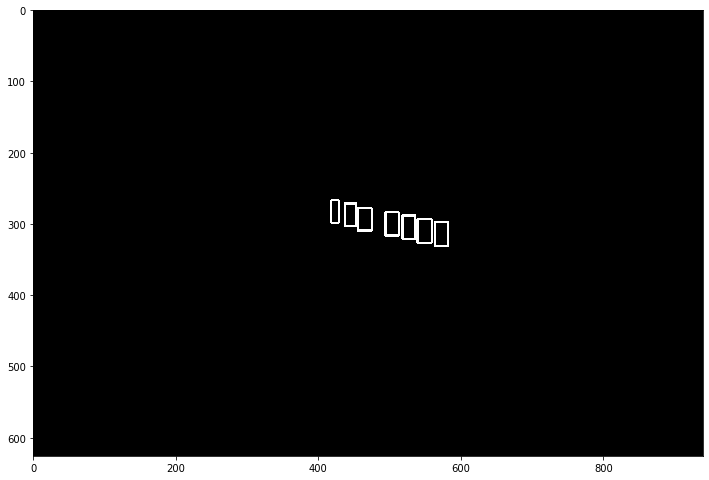

In [110]:
MAX_DIAG_MULTIPLYER = 5 # 컨투어의 대각선의 길이의 5배 안에 컨투어와 컨투어 사이의 길이가 있어야 한다.
MAX_ANGLE_DIFF = 12.0   # 컨투어와 컨투어 사이의 각도
MAX_AREA_DIFF = 0.5     # 컨투어의 면적 차이
MAX_WIDTH_DIFF = 0.8    # 컨투어의 너비 차이
MAX_HEIGHT_DIFF = 0.2   # 컨투어의 높이 차이
MIN_N_MATCHED = 3       # 컨투어의 모임이 최소 3개 이상.

"""
구조
    함수 find_chars
    {
       for()
       {
          for()
          {
           
          }

          적합한 contour list = find_chars()
          break
       }
       return contour list
    }
요약: 재귀함수 방법으로 모든 가능한 경우의 수를 리스트들을 만드는 함수이다.
     모드 번호판으로 가능한 군집을 만들어 준다.
      
참고: 정렬과 탐색은 CPU연산이 중요한 알고리즘이다.
"""

def find_chars(contour_list):
    matched_result_idx = []

    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx']==d2['idx']:
               continue
            
            dx = abs(d1['cx']-d2['cy'])
            dy = abs(d1['cy']-d2['cy'])

            # 대각선의 길이
            diagonal_length1 = np.sqrt(d1['w']**2 + d1['h']**2)

            distance = np.linalg.norm(np.array([d1['cx'],d1['cy']])-np.array([d2['cx'],d2['cy']]))

            if dx == 0:
                angle_diff = 90
            else:
                 angle_diff = np.degrees(np.arctan(dy/dx))
            area_diff = abs(d1['w']*d1['h']-d2['w']*d2['h']) / (d1['w']*d1['h'])
            width_diff = abs(d1['w']-d2['w']) / d1['w']
            height_diff = abs(d1['h']-d2['h']) / d1['h']
             
            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
               and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                   matched_contours_idx.append(d2['idx'])
            
        # append this contour
        matched_contours_idx.append(d1['idx'])

        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue
        
        matched_result_idx.append(matched_contours_idx)

        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])
        
        # 인덱스의 값을 가져오기.
        unmatched_contour = np.take(possible_contours,unmatched_contour_idx)

        # recursive
        recursive_contour_list = find_chars(unmatched_contour)

        for idx in recursive_contour_list:
            matched_result_idx.append(idx)
        
        break
    return matched_result_idx

result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours,idx_list))

# visualize possible contours
temp_result = np.zeros((height,width,channel),dtype=np.uint8)

for r in matched_result:
    for d in r:
        cv2.rectangle(temp_result,pt1=(d['x'],d['y']),pt2=(d['x']+d['w'],d['y']+d['h']),color=(255,255,255),thickness=2)

plt.figure(figsize=(12,10))
plt.imshow(temp_result,cmap='gray')


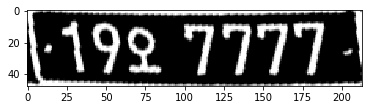

In [111]:
# Rotate Plate Images 사진상의 기울어진 Image를 수평으로 맞춰주기. / affine Transform
# 글자를 감싸고 있는 padding size 고려하기.
PLATE_WIDTH_PADDING = 1.3 # 1.3
PLATE_HEIGHT_PADDING = 1.5 # 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars,key=lambda x:x['cx'])

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) /2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) /2

    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING

    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']
    
    plate_height = int(sum_height/len(sorted_chars)*PLATE_HEIGHT_PADDING)
    # 나열된 글자의 처음과 끝을 통하여 비스듬히 되어있는 각도를 구하기(밑변과 대각선의 길이를 바탕으로))
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'],sorted_chars[0]['cy']]) -
        np.array([sorted_chars[-1]['cx'],sorted_chars[-1]['cy']])
    )

    angle = np.degrees(np.arcsin(triangle_height/triangle_hypotenus))
    
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx,plate_cy),angle=angle,scale=1.0)

    img_rotated = cv2.warpAffine(img_thresh,M=rotation_matrix,dsize=(width,height))
    
    img_cropped = cv2.getRectSubPix(
        img_rotated,
        patchSize=(int(plate_width),int(plate_height)),center=(int(plate_cx),int(plate_cy))
    )

    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
      continue

    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x':int(plate_cx - plate_width /2),
        'y':int(plate_cy - plate_height/2),
        'w':int(plate_width),
        'h':int(plate_height)
    })
    plt.subplot(len(matched_result),1,i+1)
    plt.imshow(img_cropped,cmap='gray')



In [112]:
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libtesseract-dev is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


19오7777


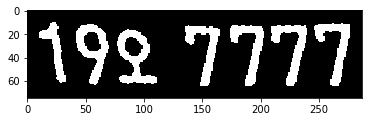

In [115]:
# 선별된 이미지를 바탕으로 pytesseract를 활용하여 문자로 변환하기
# 정확도를 높이기 위해, thresholding 을 한번 더 주고, find contours를 다시 한번 실행한 후, 맞는지 확인한다.
# 그리고 가우시안 필터링을 실행하여 노이즈를 제거하고, 번호판을 만들어줍니다. 그리고 난 후, pytesseract 를 통하여 이미지를 문자로 다시 변환을 합니다.
# cv2.resize(원본 이미지, dsize=(0, 0), 가로비, 세로비, 보간법

# 기본 임계처리
# 이진화란 영상을 흑/백으로 분류하여 처리하는 것을 말합니다. 이때 기준이 되는 임계값을 어떻게 결정할 것인지가 중요한 문제가 됩니다.
# 임계값보다 크면 백, 작으면 흑이 됩니다. 기본 임계처리는 사용자가 고정된 임계가ㅄ을 결정하고 그 결과를 보여주는 단순한 형태입니다.
# cv2.threshold(src,thresh,maxval,type) -> retval, dst
# parameters: src:input image , thresh-임계값 maxval-임계값을 넘었을 때 적용할 value, type-thresholding type
# thresholding type : THRESH_BINARY, THERSH_BINARY_INV, THRESH_TRUNC,THRESH_TOZERO, THRESH_TOZERO_INV

# 이미지를 복사하는 방법
# cv2.copyMakeBorder(src, top, bottom, left, right, borderType)
# border type : contant : 컬러 테두리 추가, reflect :cba|abc|cba 로 사진을 추가, replicate : aaa/abc/ccc로 사진을 추가

# Tesseract
# 이미지로부터 텍스트를 인식하고 , 추출하는 소프트웨어를 일반적으로 OCR이라고 한다. 
# LSTM과 같은 딥러닝 방식을 통해 텍스트 인식률을 개선하고 있다
# 참고 : https://github.com/madmaze/pytesseract

# trainned data 추가하기
# google colab side bar에서 Files에서 경로 /usr/share/tesseract-ocr/4.00/testdata 에 traineddata 추가하기
# trained data 다운로드 : https://github.com/tesseract-ocr/tessdata/blob/master/kor.traineddata
"""
        OCR Engine modes(–oem):
        0 - Legacy engine only.
        1 - Neural nets LSTM engine only.
        2 - Legacy + LSTM engines.
        3 - Default, based on what is available.

        Page segmentation modes(–psm):
        0 - Orientation and script detection (OSD) only.
        1 - Automatic page segmentation with OSD.
        2 - Automatic page segmentation, but no OSD, or OCR.
        3 - Fully automatic page segmentation, but no OSD. (Default)
        4 - Assume a single column of text of variable sizes.
        5 - Assume a single uniform block of vertically aligned text.
        6 - Assume a single uniform block of text.
        7 - Treat the image as a single text line.
        8 - Treat the image as a single word.
        9 - Treat the image as a single word in a circle.
        10 - Treat the image as a single character.
        11 - Sparse text. Find as much text as possible in no particular order.
        12 - Sparse text with OSD.
        13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific. 
"""
longest_idx, longest_text = -1, 0
plate_chars = []

for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # find contours again (same as above)
    contours, hierarchy = cv2.findContours(plate_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        ratio = w / h

        if area > MIN_AREA \
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h
                
    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
    
    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))

    # chars = pytesseract.image_to_string(img_result, lang='eng', config='--psm 1 -c preserve_interword_spaces=1')
    chars = pytesseract.image_to_string(img_result, lang='kor', config='--psm 7 --oem 0')

    result_chars = ''
    has_digit = False
    for c in chars:
        if ord('가') <= ord(c) <= ord('힣') or c.isdigit():
            if c.isdigit():
                has_digit = True
            result_chars += c
    
    print(result_chars)
    plate_chars.append(result_chars)

    if has_digit and len(result_chars) > longest_text:
        longest_idx = i

    plt.subplot(len(plate_imgs), 1, i+1)
    plt.imshow(img_result, cmap='gray')